# Assignment 1: Regression


Name: Karthik Iyer

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import random
import copy

## Problem 1: Linear Regression
Implement gradient descent algorithm to solve linear regression problem,
$$\min_x f_{\text{linear}}(x):=\frac{1}{2}\|\mathbf{F}x - \mathbf{r}\|^2 + \frac{\lambda}{2}\|x\|^2.$$

In [56]:
# Construct linear regression data

random.seed(123)
sigma = 0.05
m_linear = 500
n_linear = 100
F_linear = np.random.randn(m_linear, n_linear) 
xt_linear = np.random.randn(n_linear) 
r_linear = F_linear.dot(xt_linear) + sigma*np.random.randn(m_linear) 
lambda_linear = 0.01

In [57]:
# Define functions

def f_linear(x): 
    f = 0.5*np.inner(F_linear.dot(x) - r_linear, F_linear.dot(x) - r_linear) + \
        0.5*lambda_linear*np.inner(x, x)
    return f

def nabla_f_linear(x):
    return F_linear.T.dot(F_linear.dot(x) - r_linear) + lambda_linear*x

In [58]:
# Initialize variable and parameters

x_linear = np.zeros(n_linear)
g_linear = nabla_f_linear(x_linear)
iterMax = 500
tol = 1e-6
his_linear = np.zeros(iterMax)
beta = LA.norm(F_linear, 2)**2 + lambda_linear 
err = float('Inf')

# Gradient Descent

for noi in range(0, iterMax):
    
    # update convergence information
    x_linear = x_linear - g_linear/(beta) 
    g_linear = nabla_f_linear(x_linear)   
    
    obj = f_linear(x_linear)
    err = LA.norm(g_linear, 2)
    his_linear[noi] = err
    if err < tol:
        break

his_linear = his_linear[:noi]

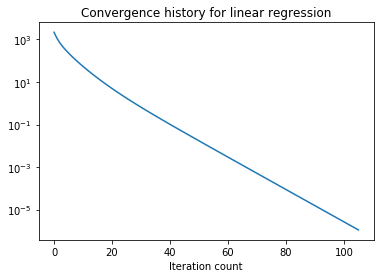

In [59]:
# Compare result

import matplotlib.pyplot as plt
plt.semilogy(his_linear)
plt.title("Convergence history for linear regression")
plt.xlabel("Iteration count")
plt.show()

## Problem 2: LASSO
Implement proximal gradient descent algorithm to solve LASSO problem,
$$\min_x f_{\text{lasso}}(x):=\frac{1}{2}\|\mathbf{F}x - \mathbf{r}\|^2 + \lambda\|x\|_1.$$

In [60]:
# Construct LASSO variables

random.seed(123)
sigma = 0.05
m_lasso = 200
n_lasso = 500
k_lasso = 10

F_lasso = np.random.randn(m_lasso, n_lasso)
# Note that F_lasso is an under-determined matrix and only k_lasso number of 
# predictors matter. It is in situations like these when we add a 1-norm penalty.

xt_lasso = np.zeros(n_lasso)

# Randomly make k components {+ 1 or -1}
for i in np.random.permutation(n_lasso)[:k_lasso]: 
    xt_lasso[i] = random.choice([-1.0, 1.0]) 

r_lasso = F_lasso.dot(xt_lasso) + sigma*np.random.randn(m_lasso)
lambda_lasso = 10.0

In [61]:
# Define functions

def f_lasso(x):
    return 0.5*np.inner(F_lasso.dot(x) - r_lasso, F_lasso.dot(x)) + lambda_lasso*LA.norm(x, 1)

def nabla_f_lasso_smooth(x):
    return F_lasso.T.dot(F_lasso.dot(x) - r_lasso)


def prox_1norm(x, t):
    # Compute the prox operator for the 1-norm
    # Refer to https://people.eecs.berkeley.edu/~elghaoui/Teaching/EE227A/lecture18.pdf
    
    y = np.zeros(x.shape)
    for i in range(len(y)):
        if x[i] >= t:
            y[i] = x[i] - t
        elif x[i] <= -t:
            y[i] = x[i] + t
        else:
            y[i] = 0
    return y

In [62]:
# Proximal Gradient Descent Iteration

# Initialize variable and parameters

x_lasso = np.zeros(n_lasso)
x_lasso_old = np.zeros(n_lasso)
iterMax = 500
tol = 1e-6
his_lasso = np.zeros(iterMax)
noi = 1
err = float('Inf')
step_size =  1.0/(LA.norm(F_lasso, 2)**2) # step size is  1/||F||^2

for noi in range(0, iterMax):
    x_lasso_old = x_lasso
    
    # If h is a non smooth function and f is a smooth function, then
    # x_new = prox_{step_size*h}(x_old - step_size*nabla f). 
    # In our case, h = lambda*||.||_{1}
    
    g_lasso = nabla_f_lasso_smooth(x_lasso)
    x_lasso = prox_1norm(x_lasso - step_size*g_lasso, lambda_lasso*step_size)
    
    obj = f_lasso(x_lasso)
    err = LA.norm(x_lasso - x_lasso_old, 2)
    his_lasso[noi] = err
    if err < tol:
        break
his_lasso = his_lasso[:noi]

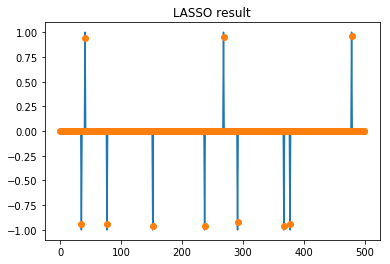

In [63]:
# Plot result

plt.plot(xt_lasso)
plt.plot(x_lasso, "o")
plt.title("LASSO result")
plt.show()

Lasso picks out the non zero signals!

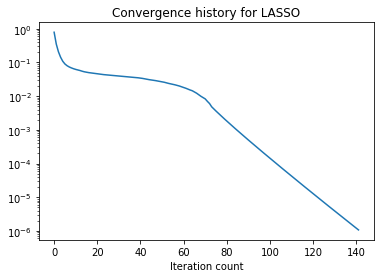

In [64]:
# Plot convergence history

plt.semilogy(his_lasso)
plt.title("Convergence history for LASSO")
plt.xlabel("Iteration count")
plt.show()

## Problem 3: Robust Regression
Implement proximal gradient descent algorithm to solve robust regression problem,

$$\min_x f_{\text{robust}}(x):=\rho_\kappa\left(\mathbf{F}x - \mathbf{r}\right) + \lambda\|x\|_1.$$ where 
$\rho_{\kappa}$ is the Huber function. 

In [65]:
# Construct Robust Regression variables

random.seed(123)
sigma = 0.05
m_robust = 200
n_robust = 500
k_robust = 10
F_robust = np.random.randn(m_robust,n_robust)
xt_robust = np.zeros(n_robust)

for i in np.random.permutation(n_robust)[:k_robust]:
    xt_robust[i] = random.choice([-1.0, 1.0]) 

r_robust = F_robust.dot(xt_robust) + sigma*np.random.randn(m_robust)
for i in np.random.permutation(m_robust)[:k_robust]:
    r_robust[i] += 5.0*np.random.randn()
    
lambda_robust = 2.0
kappa_robust = 0.1

In [66]:
# Define functions

def rho(a):
    val = 0.0
    for i in range(len(a)):
        if a[i] > kappa_robust:
            val += kappa_robust*abs(a[i]) - 0.5*kappa_robust*kappa_robust
        else:
            val += 0.5*a[i]*a[i]
    return val

def f_robust(x):
    return rho(F_robust.dot(x) - r_robust) + lambda_robust*LA.norm(x, 1)


def nabla_f_robust_smooth(x):
    
    # Calculate and return gradient of the smooth part
    y = F_robust.dot(x) - r_robust
    nabla_rho = np.zeros(x.shape)
    for i in range(len(y)):
        if y[i] > kappa_robust:
            nabla_rho[i] = kappa_robust*np.sign(y[i])
        else:
            nabla_rho[i] = y[i]
    return F_robust.T.dot(y)

In [67]:
# Initialize variable and parameters

x_robust = np.zeros(n_robust)
x_robust_old = np.zeros(n_robust)
g_robust = nabla_f_robust_smooth(x_robust)
iterMax = 10000
tol = 1e-6
his_robust = np.zeros(iterMax)
step_size =  1.0/(LA.norm(F_robust, 2)**2)
err = float('Inf')

# Proximal Gradient Descent Iteration

for noi in range(iterMax):
    x_robust_old = x_robust
    g_robust = nabla_f_robust_smooth(x_robust)
    x_robust = prox_1norm(x_robust - step_size*g_robust, lambda_robust*step_size) 
    obj = f_robust(x_robust)
    err = LA.norm(x_robust - x_robust_old, 2)
    his_robust[noi] = err
    if err < tol:
        break
    
his_robust = his_robust[:noi]

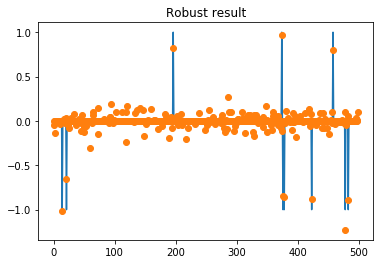

In [68]:
# Plot result

plt.plot(xt_robust)
plt.plot(x_robust, "o")
plt.title("Robust result")
plt.show()

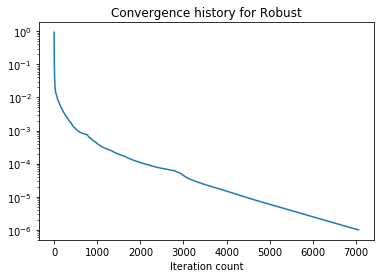

In [70]:
# Plot convergence history

plt.semilogy(his_robust)
plt.title("Convergence history for Robust")
plt.xlabel("Iteration count")
plt.show()

## Problem 4: Logistic Regression
Fill in the blanks to implement proximal gradient descent algorithm to solve logistic regression problem,
$$\min_x f_{\text{logistic}}(x):= \sum_{i=1}^m\left\{\log\left(1+\exp{\left\langle f^i, x\right\rangle}\right) - s^i\left\langle f^i,x\right\rangle\right\} + \frac{\lambda}{2}\|x\|^2,$$
where $s^i\in\{0,1\}$ indicate the buy or sell.

For this problem we will use real data from [Numerai](https://numer.ai/leaderboard).
The data set consist of three parts, train data, validation data and test data.

In [43]:
# Function that reads data

def readdata(filename, datatype):
    fid = open(filename, "rb")
    data = np.fromfile(fid, datatype)
    fid.close()
    return data

In [44]:
# Dimensions of the data

n_features = 50
m_train = 2000
m_validate = 500
m_test = 500

In [71]:
train_features = readdata("train_features.bin", np.float64) # size: m_train*n_features
train_target = readdata("train_target.bin", np.float64) # size: m_train
validate_features = readdata("validate_features.bin", np.float64) # size: m_validate*n_features
validate_target = readdata("validate_target.bin", np.float64) # size: m_validate
test_features = readdata("test_features.bin", np.float64) # size: m_test*n_features
test_target = readdata("test_target.bin",np.float64) # size: m_test

# Reshape data. Note that the order of parameters to reshape. 
# This is beause of the how Python reads data.

train_features = np.reshape(train_features, (n_features, m_train)).T
validate_features = np.reshape(validate_features, (n_features, m_validate)).T
test_features = np.reshape(test_features, (n_features, m_test)).T

### Train and Validate Data
Do regression on training data with different $\lambda$, and test it on the validation data set. Pick the $\lambda$ that has the smallest error.

In [72]:
# Define functions

def f_logistic(x, lambda_logistic):
    r = train_features.dot(x)
    return np.sum(np.log(1.0 + np.exp(r))) - np.inner(train_target, r) + \
           0.5*lambda_logistic*LA.norm(x,2)**2


def nabla_f_logistic(x, lambda_logistic):
    r = train_features.dot(x)
    g = train_features.T.dot((1.0/(1.0 + np.exp(-r))) - train_target) + lambda_logistic*x
    return g

In [73]:
# Build solver function

def logistic_solver(x, lambda_logistic):
    
    # Initialize variable and parameters
    stepsize = 1.0/(LA.norm(train_features, 2)**2 + lambda_logistic) # stepsize = 1/beta for grad descent

    g  = nabla_f_logistic(x, lambda_logistic)
    
    iterMax = 200000
    tol = 1e-6
    his = np.zeros(iterMax)
    err = float('Inf')
    
    for noi in range(iterMax):
        x = x - stepsize*g
        g = nabla_f_logistic(x, lambda_logistic)
        obj = f_logistic(x, lambda_logistic)
        err = LA.norm(g, 2)
        his[noi] = obj
        if err < tol:
            break
            
    his = his[:noi]
    return x, his

In [74]:
# Predict accuracy

def predErr(features, target, x):
    r = features.dot(x)
    val = 0.0
    for i in range(len(r)):
        if (r[i] > 0.0 and target[i] == 0.0):
            val += 1
        if (r[i] < 0.0 and target[i] == 1.0):
            val += 1
    return val/len(r)

In [75]:
# Compute validation error for different tuning parameters.

lambda_logistic_set = [1.4, 1.2, 1.0, 0.8, 0.6, 0.4, 0.2]
x_set = np.ones((len(lambda_logistic_set), n_features))
validate = np.zeros(len(lambda_logistic_set))

for i, lambda_value in enumerate(lambda_logistic_set):
    if i > 0 :
        x_set[i] = copy.copy(x_set[i-1])
    x, his = logistic_solver(x_set[i], lambda_value)
    validate[i] = predErr(validate_features, validate_target, x)
    x_set[i] = x

In [76]:
# Choose the index with smallest validation prediction error. 
idx = np.argmin(validate) 

# Choose the regularization parameter that gives the lowest prediction error.
lambda_logistic_set[idx] 

# Threshold validation met as prediction error is smallest. Exit the training.
x = x_set[idx] 

In [77]:
1 - predErr(test_features, test_target, x) # About 54.4 percent accuracy

0.544